In [46]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import gzip
from scipy.stats import chisquare, kstest, spearmanr,pearsonr, kendalltau
import scipy.stats as ss
import sys
import random
try:
    from google.colab import drive
    IN_COLAB = True
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    s = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_describe.py')
    with open('RNA_describe.py', 'w') as f:
      f.write(s.text)  # writes to cloud local, delete the file later?
    s = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/GenCodeTools.py')
    with open ('GenCodeTools.py', 'w') as f:
      f.write(s.text)
    s = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/plot_generator.py')
    with open('plot_generator.py', 'w') as f:
      f.write(s.text)
    s = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/KmerTools.py')
    with open('KmerTools.py', 'w') as f:
      f.write(s.text)  
    from KmerTools import KmerTools
    from RNA_describe import *
    from GenCodeTools import *
    from plot_generator import *
except:
    print("CoLab not working. On my PC, use relative paths.")
    IN_COLAB = False
    DATAPATH='../data/'  # must end in "/"
    sys.path.append("..") # append parent dir in order to use sibling dirs
    from SimTools.RNA_describe import *
    from SimTools.GenCodeTools import *
    from SimTools.plot_generator import *
    from SimTools.KmerTools import KmerTools

MODELPATH="BestModel"  # saved on cloud instance and lost after logout
#MODELPATH=DATAPATH+MODELPATH  # saved on Google Drive but requires login

if not assert_imported_RNA_describe():
    print("ERROR: Cannot use RNA_describe.")

On Google CoLab, mount cloud-local file, get our code from GitHub.
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [47]:
PC_FILENAME='gencode.v38.pc_transcripts.fa.gz'
NC_FILENAME='gencode.v38.lncRNA_transcripts.fa.gz'
MAX_K =4
PC_FULLPATH=DATAPATH+PC_FILENAME
NC_FULLPATH=DATAPATH+NC_FILENAME
loader=GenCodeLoader()
loader.set_label(1)
loader.set_check_list(None) 
loader.set_check_utr(True)
pcdf=loader.load_file(PC_FULLPATH)
print("PC seqs loaded:",len(pcdf))
loader.set_label(0)
loader.set_check_list(None)
loader.set_check_utr(False)
ncdf=loader.load_file(NC_FULLPATH)
print("NC seqs loaded:",len(ncdf))

PC seqs loaded: 70825
NC seqs loaded: 48752


In [48]:
APPLY_SUBSET = True             #Option to subset the data
MINIMUM_SEQUENCE_LENGTH = 0     #Minimum inclusive length to filter out sequences by
MAXIMUM_SEQUENCE_LENGTH = sys.maxsize  #Maximum inclusive length to filter out sequences by
SAMPLE_FRACTION = 0.5           #What fraction of the GenCode data set to take a sample of
REPRODUCABILITY_SEED = 314159   #Use to reproduce random sampling

In [49]:
def subset_list_by_len_bounds(input_list, min_len, max_len):
  return list(filter(lambda x: len(x) > min_len and len(x) <= max_len, input_list))

In [50]:
pc_sequences = pcdf['sequence'].tolist()
nc_sequences = ncdf['sequence'].tolist()

if APPLY_SUBSET:
  pc_sequences = subset_list_by_len_bounds(pc_sequences, MINIMUM_SEQUENCE_LENGTH, MAXIMUM_SEQUENCE_LENGTH)
  nc_sequences = subset_list_by_len_bounds(nc_sequences, MINIMUM_SEQUENCE_LENGTH, MAXIMUM_SEQUENCE_LENGTH)

  print('PC seqs in length range','('+str(MINIMUM_SEQUENCE_LENGTH),'-',str(MAXIMUM_SEQUENCE_LENGTH)+'):', len(pc_sequences))
  print('NC seqs in length range','('+str(MINIMUM_SEQUENCE_LENGTH),'-',str(MAXIMUM_SEQUENCE_LENGTH)+'):', len(nc_sequences))

#Garbage collection
pcdf = None
ncdf = None

PC seqs in length range (0 - 9223372036854775807): 70825
NC seqs in length range (0 - 9223372036854775807): 48752


In [51]:
tool = KmerTools()

#This function returns list of three values (pearson, kendall and spearman coefficeints)
def getCoefficients(seq1, seq2,kmer_count):
  pearson=[]
  kendall= []
  spearman= []
  kmer_one = tool.make_dict_upto_K(kmer_count)
  kmer_two = tool.make_dict_upto_K(kmer_count)
 
  #Filling dict made above with the values 

  tool.update_count_one_K(kmer_one, kmer_count, seq1)
  tool.update_count_one_K(kmer_two, kmer_count, seq2)

  #Refilling the kmer dict with their respective frequency. 
  freq_one = list(tool.count_to_frequency(kmer_one, kmer_count).values())
  freq_two = list(tool.count_to_frequency(kmer_two, kmer_count).values())

  coeff_p, p = pearsonr(freq_one, freq_two)
  coeff_k, p = kendalltau(freq_one, freq_two)
  coeff_s, p = spearmanr(freq_one, freq_two)
  pearson.append(coeff_p)
  kendall.append(coeff_k)
  spearman.append(coeff_s)
  return (pearson, kendall, spearman)


In [52]:
samplepc = random.sample(pc_sequences,100)
samplenc = random.sample(nc_sequences,100)
  

## Comparing PC sequences among themselves

In [53]:
count =0
#Stores the three coefficients given out of getCoefficients.
coefficient_pc_pearson = []
coefficient_pc_kendall = []
coefficient_pc_spearman = []

while(count<50):
  count_two=50
  while(count_two<100):
    coefficients = getCoefficients(samplepc[count], samplepc[count_two], MAX_K)
    coefficient_pc_pearson.append(coefficients[0])
    coefficient_pc_kendall.append(coefficients[1])
    coefficient_pc_spearman.append(coefficients[2])

    count_two+=1
  count+=1





## Comparing NC sequences among themselves

In [54]:
count =0
#Stores the three coefficients given out of getCoefficients.
coefficient_nc_pearson = []
coefficient_nc_kendall = []
coefficient_nc_spearman = []
while(count<50):
  count_two=50
  while(count_two<100):
    coefficients = getCoefficients(samplenc[count], samplenc[count_two], MAX_K)
    coefficient_nc_pearson.append(coefficients[0])
    coefficient_nc_kendall.append(coefficients[1])
    coefficient_nc_spearman.append(coefficients[2])
    count_two+=1
  count+=1

In [55]:
count =0
#Stores the three coefficients given out of getCoefficients.
coefficient_mix_pearson = []
coefficient_mix_kendall = []
coefficient_mix_spearman = []
while(count<100):
  count_two=0
  while(count_two<100):
    coefficients = getCoefficients(samplepc[count], samplenc[count_two], MAX_K)
    coefficient_mix_pearson.append(coefficients[0])
    coefficient_mix_kendall.append(coefficients[1])
    coefficient_mix_spearman.append(coefficients[2])
    count_two+=1
  count+=1

## Plotting Spearman Coefficients for PC-PC comparison, NC-NC and PC-NC comparision. 

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


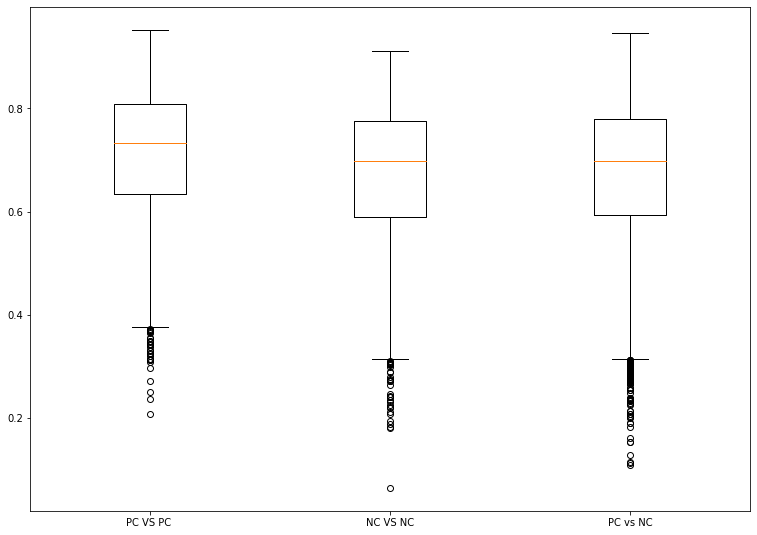

In [56]:
fig = plt.figure(figsize =(10, 7))
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
data =[coefficient_pc_spearman,coefficient_nc_spearman,coefficient_mix_spearman]
title = ["PC VS PC ", "NC VS NC", "PC vs NC"]
# Creating plot
bp = ax.boxplot(data)
ax.set_xticklabels(title)
# show plot
plt.show()

## Comparing PC vs PC , NC vs NC and PC vs NC using Pearson

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


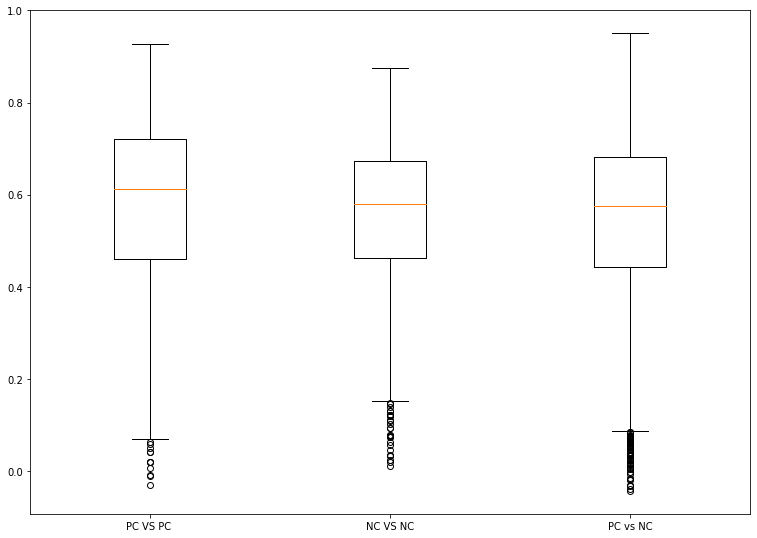

In [57]:
fig = plt.figure(figsize =(10, 7))
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
data =[coefficient_pc_pearson,coefficient_nc_pearson,coefficient_mix_pearson]
title = ["PC VS PC ", "NC VS NC", "PC vs NC"]
# Creating plot
bp = ax.boxplot(data)
ax.set_xticklabels(title)
# show plot
plt.show()

USing Kendall Coefficients


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


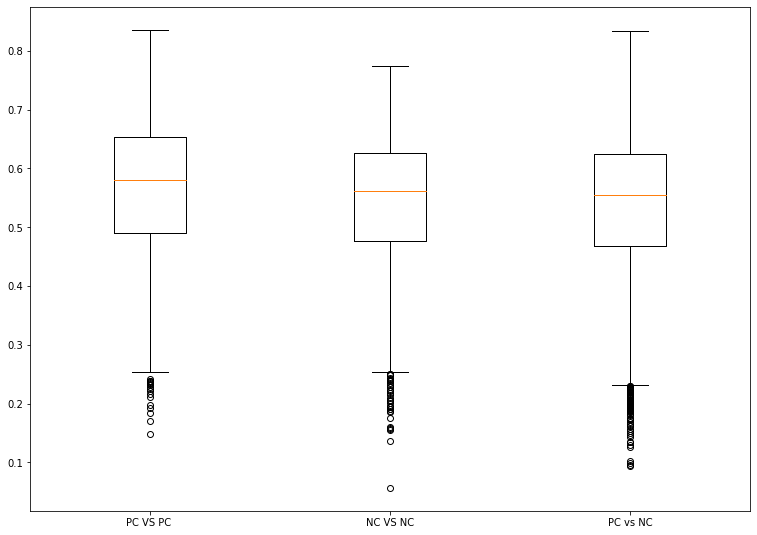

In [58]:
fig = plt.figure(figsize =(10, 7))
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
data =[coefficient_pc_kendall,coefficient_nc_kendall,coefficient_mix_kendall]
title = ["PC VS PC ", "NC VS NC", "PC vs NC"]
# Creating plot
bp = ax.boxplot(data)
ax.set_xticklabels(title)
# show plot
plt.show()